In [ ]:
%matplotlib inline


# Vocal separation

This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

<div class="alert alert-danger"><h4>Warning</h4><p>This example is primarily of historical interest, and we do not recommend
    this as a competitive method for vocal source separation.
    For a more recent treatment of vocal and music source separation, please
    refer to [Open Source Tools & Data for Music Source Separation](https://source-separation.github.io/tutorial/landing.html) [1]_.</p></div>

This is based on the "REPET-SIM" method of [Rafii and Pardo, 2012](http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf)
[2]_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon)
      [3]_,
      but is a bit more numerically stable in practice.

.. [1] Manilow, Ethan, Prem Seetharman, and Justin Salamon.
    "Open source tools & data for music source separation."
    2020.

.. [2] Rafii, Zafar, and Bryan Pardo.
    "Music/Voice Separation Using the Similarity Matrix."
    In ISMIR, pp. 583-588. 2012.

.. [3] FitzGerald, Derry.
    "Vocal separation using nearest neighbours and median filtering."
    23rd IET Irish Signals and Systems Conference, Maynooth.  (2012): 98-98.


In [ ]:

##################
# Declararea librariilor
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

from google.colab import drive
import shutil
import soundfile as sf

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Introducerea unui fisier vocal



In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/PSV/separarea semnalului de voce/fisiere de intrare/m1.wav', sr=None, duration=120)
#y, sr = librosa.load(librosa.ex('libri1'), duration=120)


#Calcularea spectrului de amplitudine si fazei semnalului
S_full, phase = librosa.magphase(librosa.stft(y))

#Redarea unui fragment de 5 secunde care sa includa voce
Audio(data=y[12*sr:17*sr], rate=sr)

In [ ]:
sf.write('/content/fisier_de_intrare_x.wav',y[12*sr:17*sr], sr)
drive_folder_path_1 = '/content/drive/MyDrive/PSV/separarea semnalului de voce/fisier cu segmente audio needitate'  # Se citeste calea unde trebuie salvat fisierul

shutil.move('/content/fisier_de_intrare_x.wav', drive_folder_path_1)

'/content/drive/MyDrive/PSV/separarea semnalului de voce/fisier cu segmente audio needitate/fisier_de_intrare_x.wav'

Analiza spectrala a unui segment de 5 secunde din fisierul initial



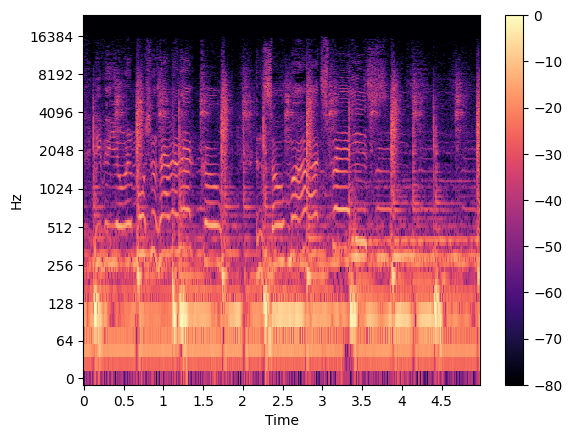

In [ ]:
idx = slice(*librosa.time_to_frames([12, 17], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

Liniile cu o culoarea mai apropiata de valoarea 0 sunt corespunzatoare semnalului vocal, cele cu o valoare mai indepartata de 0 fiind pentru semnalul instrumental



In [ ]:
#Se realizeaza o filtrarea cu ajutorul metodei cosinsului si se vor compara cadrele asemanatoare, determinandu-se astfel valoarea mediana a semnalului de voce.

#Cadrele trebuie sa fie separate de o perioada de timp de 2 secunde, pentru a evita abaterile scurte de la valoarea mediana.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

#Iesirea filtrului trebuie sa fie mai mica decat intrarea
S_filter = np.minimum(S_full, S_filter)

Aplicarea unei masti pentru a avea un rezultat final mai calitativ



In [ ]:
#Se utilizaeaza o marja de eroare, pentru a evita problemele de suprapunere intre semnalul vocal si instrumental
#Nota: marginile nu trebuie sa fie egale, pentru a avea o separare corecta a semnalelor
#din semnalul filtrat se scade cel original
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

#din semnalul original se scade cel filtrat
mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

#Dupa obtinerea mastilor, acestea se inmultesc cu spectrul de intrarea pentru a putea separa componentele

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Separarea semnalelor



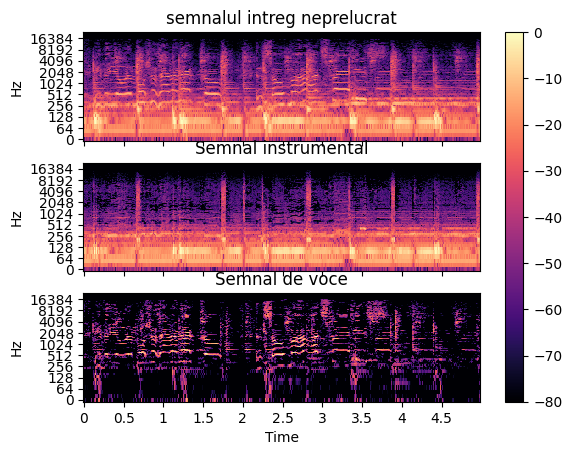

In [ ]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='semnalul intreg neprelucrat')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Semnal instrumental')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Semnal de voce')
fig.colorbar(img, ax=ax)

Recuperarea semnalului vocal



In [ ]:
y_foreground = librosa.istft(S_foreground * phase)
#Redarea unui segment de 5 secunde, care sa contina si voce, din fisierul audio initial
Audio(data=y_foreground[12*sr:17*sr], rate=sr)


In [ ]:
sf.write('/content/fisier_de_iesire_x.wav',y_foreground[12*sr:17*sr], sr)
drive_folder_path_2 = '/content/drive/MyDrive/PSV/separarea semnalului de voce/fisiere cu segmente audio editate'  # Calea pentru salvarea fisierului de output

shutil.move('/content/fisier_de_iesire_x.wav', drive_folder_path_2)

'/content/drive/MyDrive/PSV/separarea semnalului de voce/fisiere cu segmente audio editate/fisier_de_iesire_x.wav'